In [1]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from wishpy.dataworker import DataWorker
dw = DataWorker(google_secret='../../../wishpy/client_secret.json')
import math

# from scipy import stats
from scipy.stats import chi2, chi2_contingency
import statsmodels.stats.api as sms

import ttd_experiment as ttd

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/wishpy/dataworker.py:83: UserWarning: [Errno 2] No such file or directory: '../../../wishpy/client_secret.json'
  warnings.warn(str(e))


In [20]:
df_lrr = dw.td_query('''
select (case 
          when groups = 'ttd_estimate_service_control' then 'ttd_estimate_service_control_30popu'
          when groups = 'ttd_estimate_service_show' then 'ttd_estimate_service_show_20p_80p_20popu'
          when groups = 'ttd_estimate_service_show-v2' then 'ttd_estimate_service_show_v2_10p_80p_10popu'
          when groups = 'ttd_estimate_service_show-v3' then 'ttd_estimate_service_show_v3_10p_60p_10popu'
          when groups = 'ttd_estimate_service_show-v4' then 'ttd_estimate_service_show_v4_20p_50p_10popu'
          when groups = 'ttd_estimate_service_show-v5' then 'ttd_estimate_service_show_v5_50p_70p_10popu'
          else 'other'
        end) as new_groups
       ,count(user_id) as user_count
       
       ,round(avg(lrr),4) as lrr_userid_based
       ,round(STDDEV(lrr),4) as llr_stddev_userid_based
       ,round(avg(non_log_rr),4) as non_log_rr_userid_based
       ,round(STDDEV(non_log_rr),4) as non_log_rr_stddev_userid_based
       ,round(avg(overall_rr),4) as overall_rr_userid_based
       ,round(STDDEV(overall_rr),4) as overall_rr_stddev_userid_based
       
       ,sum(orders) as orders
       ,sum(l_refund_orders) as l_refund_orders
       ,sum(non_l_refund_orders) as non_l_refund_orders
       ,sum(overall_refund_orders) as overall_refund_orders
       ,round(100.0*sum(l_refund_orders)/sum(orders),4)/100.0 as lrr_txn_based
       ,round(100.0*sum(non_l_refund_orders)/sum(orders),4)/100.0 as non_l_rr_txn_based
       ,round(100.0*sum(overall_refund_orders)/sum(orders),4)/100.0 as overall_rr_txn_based
from (
select groups
       ,user_id
       ,count(m_transaction_id) as orders
       ,count(if(refund_reason_category in (20,35,38),m_transaction_id,NULL)) as l_refund_orders
       ,count(if(refund_reason_category not in (20,35,38),m_transaction_id,NULL)) as non_l_refund_orders
       ,count(if(refund_reason_category is not NULL,m_transaction_id,NULL)) as overall_refund_orders
       
       ,round(count(if(refund_reason_category in (20,35,38),m_transaction_id,NULL))/count(m_transaction_id),4) as lrr
       ,round(count(if(refund_reason_category not in (20,35,38),m_transaction_id,NULL))/count(m_transaction_id),4) as non_log_rr
       ,round(count(if(refund_reason_category is not NULL,m_transaction_id,NULL))/count(m_transaction_id),4) as overall_rr
from analytics.jay_ttd_exp_lrr_20190522_20190709
where groups != 'other'
group by groups
       ,user_id
) as temp
group by groups
'''
# ,job_id=725816212
,engine = 'presto'
                )

You can look at job id 726685914


In [28]:
df_lrr_dt = dw.td_query('''
select (case 
          when groups = 'ttd_estimate_service_control' then 'ttd_estimate_service_control_30popu'
          when groups = 'ttd_estimate_service_show' then 'ttd_estimate_service_show_20p_80p_20popu'
          when groups = 'ttd_estimate_service_show-v2' then 'ttd_estimate_service_show_v2_10p_80p_10popu'
          when groups = 'ttd_estimate_service_show-v3' then 'ttd_estimate_service_show_v3_10p_60p_10popu'
          when groups = 'ttd_estimate_service_show-v4' then 'ttd_estimate_service_show_v4_20p_50p_10popu'
          when groups = 'ttd_estimate_service_show-v5' then 'ttd_estimate_service_show_v5_50p_70p_10popu'
          else 'other'
        end) as new_groups
       ,order_dt
       
       ,count(user_id) as user_count
       
       ,round(avg(lrr),4) as lrr_userid_based
       ,round(STDDEV(lrr),4) as llr_stddev_userid_based
       ,round(avg(non_log_rr),4) as non_log_rr_userid_based
       ,round(STDDEV(non_log_rr),4) as non_log_rr_stddev_userid_based
       ,round(avg(overall_rr),4) as overall_rr_userid_based
       ,round(STDDEV(overall_rr),4) as overall_rr_stddev_userid_based
       
       ,sum(orders) as orders
       ,sum(l_refund_orders) as l_refund_orders
       ,sum(non_l_refund_orders) as non_l_refund_orders
       ,sum(overall_refund_orders) as overall_refund_orders
       ,round(100.0*sum(l_refund_orders)/sum(orders),4)/100.0 as lrr_txn_based
       ,round(100.0*sum(non_l_refund_orders)/sum(orders),4)/100.0 as non_l_rr_txn_based
       ,round(100.0*sum(overall_refund_orders)/sum(orders),4)/100.0 as overall_rr_txn_based
from (
select groups
       ,order_dt
       ,user_id
       ,count(m_transaction_id) as orders
       ,count(if(refund_reason_category in (20,35,38),m_transaction_id,NULL)) as l_refund_orders
       ,count(if(refund_reason_category not in (20,35,38),m_transaction_id,NULL)) as non_l_refund_orders
       ,count(if(refund_reason_category is not NULL,m_transaction_id,NULL)) as overall_refund_orders
       
       ,round(count(if(refund_reason_category in (20,35,38),m_transaction_id,NULL))/count(m_transaction_id),4) as lrr
       ,round(count(if(refund_reason_category not in (20,35,38),m_transaction_id,NULL))/count(m_transaction_id),4) as non_log_rr
       ,round(count(if(refund_reason_category is not NULL,m_transaction_id,NULL))/count(m_transaction_id),4) as overall_rr
from analytics.jay_ttd_exp_lrr_20190522_20190709
where groups != 'other'
group by groups
       ,order_dt
       ,user_id
) as temp
group by groups
       ,order_dt
'''
# ,job_id=725816212
,engine = 'presto'
                )

You can look at job id 726702263


In [27]:
df_lrr_dt_country = dw.td_query('''
select (case 
          when groups = 'ttd_estimate_service_control' then 'ttd_estimate_service_control_30popu'
          when groups = 'ttd_estimate_service_show' then 'ttd_estimate_service_show_20p_80p_20popu'
          when groups = 'ttd_estimate_service_show-v2' then 'ttd_estimate_service_show_v2_10p_80p_10popu'
          when groups = 'ttd_estimate_service_show-v3' then 'ttd_estimate_service_show_v3_10p_60p_10popu'
          when groups = 'ttd_estimate_service_show-v4' then 'ttd_estimate_service_show_v4_20p_50p_10popu'
          when groups = 'ttd_estimate_service_show-v5' then 'ttd_estimate_service_show_v5_50p_70p_10popu'
          else 'other'
        end) as new_groups
       ,order_dt
       ,shipping_country
       ,count(user_id) as user_count
       
       ,round(avg(lrr),4) as lrr_userid_based
       ,round(STDDEV(lrr),4) as llr_stddev_userid_based
       ,round(avg(non_log_rr),4) as non_log_rr_userid_based
       ,round(STDDEV(non_log_rr),4) as non_log_rr_stddev_userid_based
       ,round(avg(overall_rr),4) as overall_rr_userid_based
       ,round(STDDEV(overall_rr),4) as overall_rr_stddev_userid_based
       
       ,sum(orders) as orders
       ,sum(l_refund_orders) as l_refund_orders
       ,sum(non_l_refund_orders) as non_l_refund_orders
       ,sum(overall_refund_orders) as overall_refund_orders
       ,round(100.0*sum(l_refund_orders)/sum(orders),4)/100.0 as lrr_txn_based
       ,round(100.0*sum(non_l_refund_orders)/sum(orders),4)/100.0 as non_l_rr_txn_based
       ,round(100.0*sum(overall_refund_orders)/sum(orders),4)/100.0 as overall_rr_txn_based
from (
select groups
       ,order_dt
       ,shipping_country
       ,user_id
       ,count(m_transaction_id) as orders
       ,count(if(refund_reason_category in (20,35,38),m_transaction_id,NULL)) as l_refund_orders
       ,count(if(refund_reason_category not in (20,35,38),m_transaction_id,NULL)) as non_l_refund_orders
       ,count(if(refund_reason_category is not NULL,m_transaction_id,NULL)) as overall_refund_orders
       
       ,round(count(if(refund_reason_category in (20,35,38),m_transaction_id,NULL))/count(m_transaction_id),4) as lrr
       ,round(count(if(refund_reason_category not in (20,35,38),m_transaction_id,NULL))/count(m_transaction_id),4) as non_log_rr
       ,round(count(if(refund_reason_category is not NULL,m_transaction_id,NULL))/count(m_transaction_id),4) as overall_rr
from analytics.jay_ttd_exp_lrr_20190522_20190709
where groups != 'other'
group by groups
       ,order_dt
       ,shipping_country
       ,user_id
) as temp
group by groups
       ,order_dt
       ,shipping_country
'''
# ,job_id=725816212
,engine = 'presto'
                )

You can look at job id 726701729


In [18]:
df_lrr_dt.head()

new_groups    order_dt  user_count  \
0     ttd_estimate_service_show_20p_80p_20popu  2019-06-07      111995   
1          ttd_estimate_service_control_30popu  2019-06-23      166367   
2  ttd_estimate_service_show_v4_20p_50p_10popu  2019-06-12       57564   
3  ttd_estimate_service_show_v2_10p_80p_10popu  2019-06-29      111386   
4  ttd_estimate_service_show_v5_50p_70p_10popu  2019-06-18       48653   

   lrr_userid_based  llr_stddev_userid_based  non_log_rr_userid_based  \
0            0.0414                   0.1991                   0.0525   
1            0.0383                   0.1920                   0.0557   
2            0.0505                   0.2189                   0.0452   
3            0.0421                   0.2008                   0.0516   
4            0.0441                   0.2053                   0.0531   

   non_log_rr_stddev_userid_based  overall_rr_userid_based  \
0                          0.2231                   0.0973   
1                          0.2294                   0.0968   
2                          0.2077                   0.0991   
3                          0.2211                   0.0970   
4                          0.2243                   0.1008   

   overall_rr_stddev_userid_based  orders  l_refund_orders  \
0                          0.2963  322936            17953   
1                          0.2957  463071            23134   
2                          0.2988  160649            10572   
3                          0.2960  313540            16705   
4                          0.3010  131093             7423   

   non_l_refund_orders  overall_refund_orders  lrr_txn_based  \
0                24963                  42916       0.055593   
1                34813                  57947       0.049958   
2                11076                  21648       0.065808   
3                23677                  40382       0.053279   
4                 9944                  17367       0.056624   

   non_l_rr_txn_based  overall_rr_txn_based  
0            0.077300              0.132893  
1            0.075179              0.125136  
2            0.068945              0.134753  
3            0.075515              0.128794  
4            0.075855              0.132478

## LRR overall over date plot

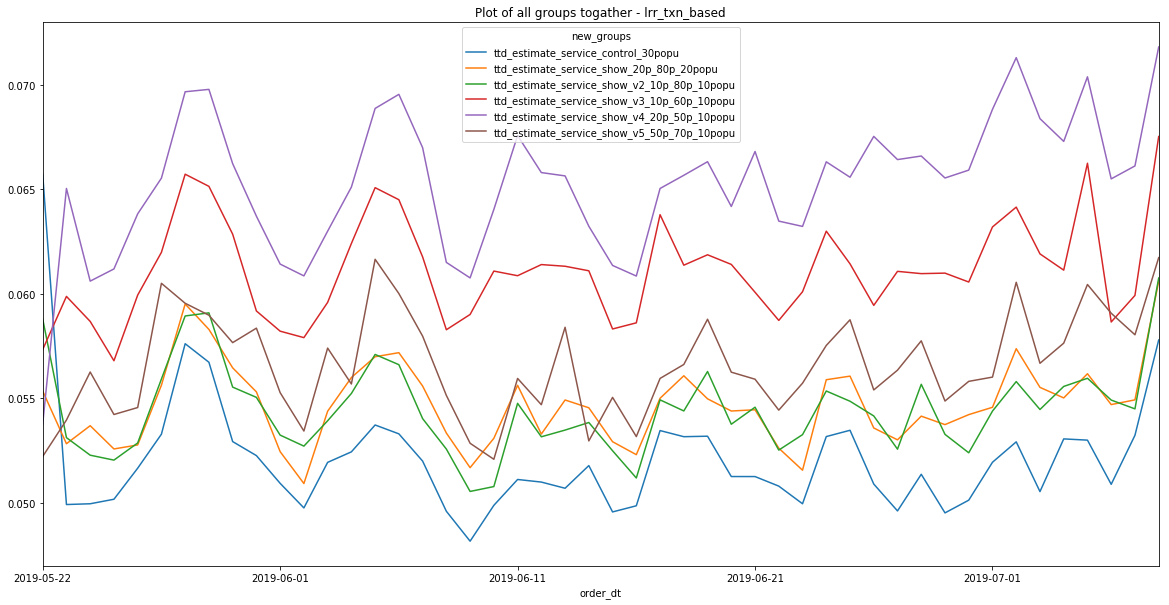

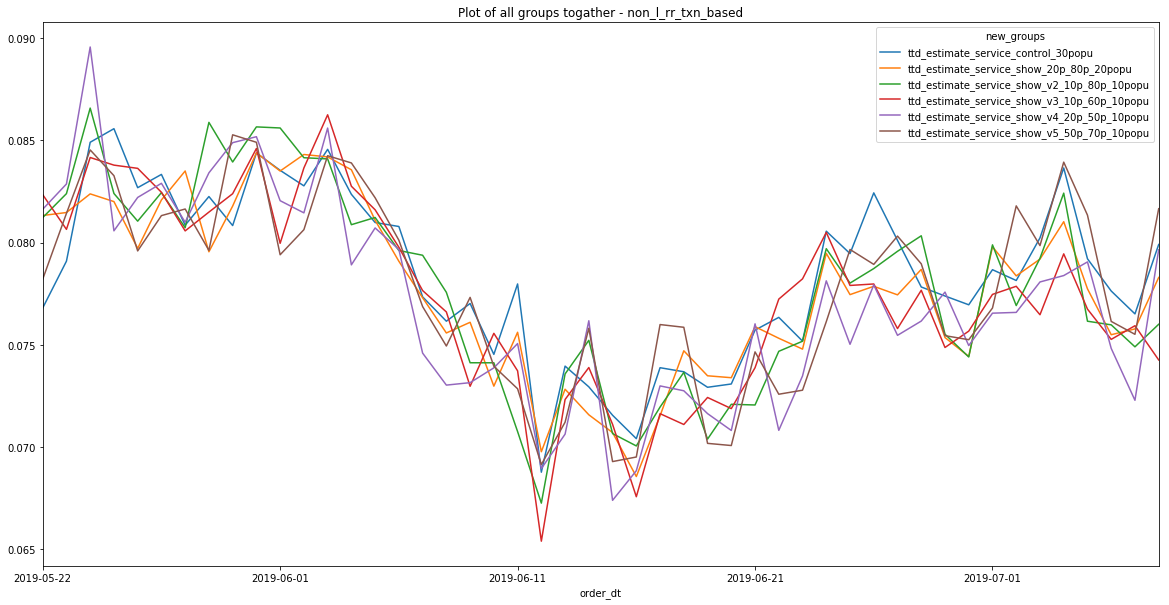

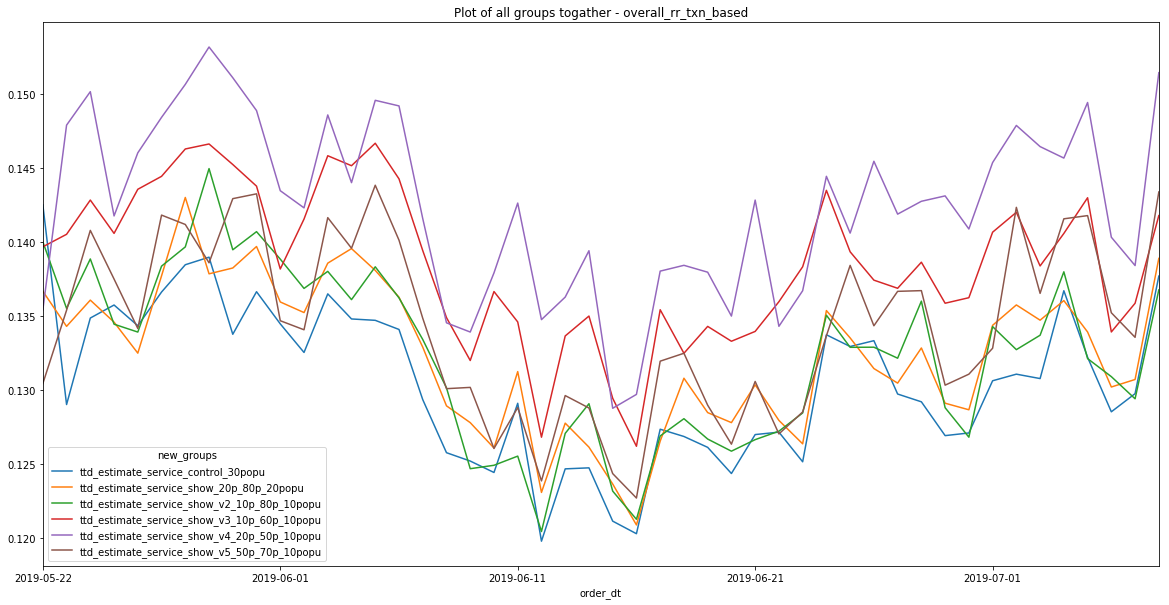

In [15]:
metrics = ['lrr_txn_based','non_l_rr_txn_based','overall_rr_txn_based']
for metric in metrics:
    df_lrr_dt[['order_dt','new_groups',metric]].pivot_table(columns='new_groups', values=metric, index='order_dt').plot(figsize=(20, 10))
    plt.title('Plot of all groups togather - {}'.format(metric))

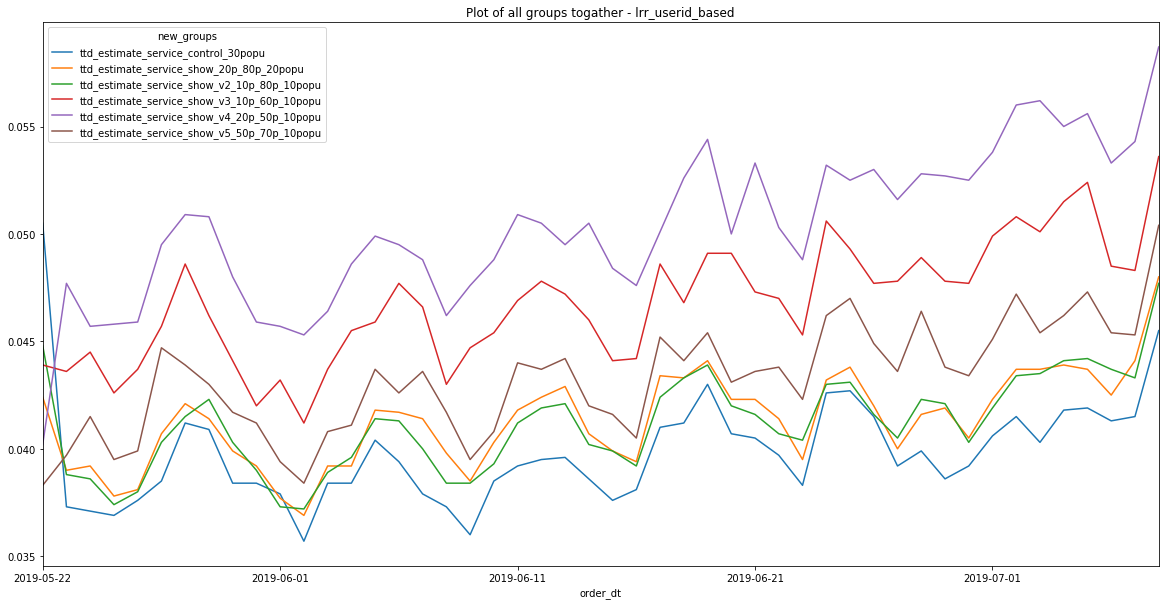

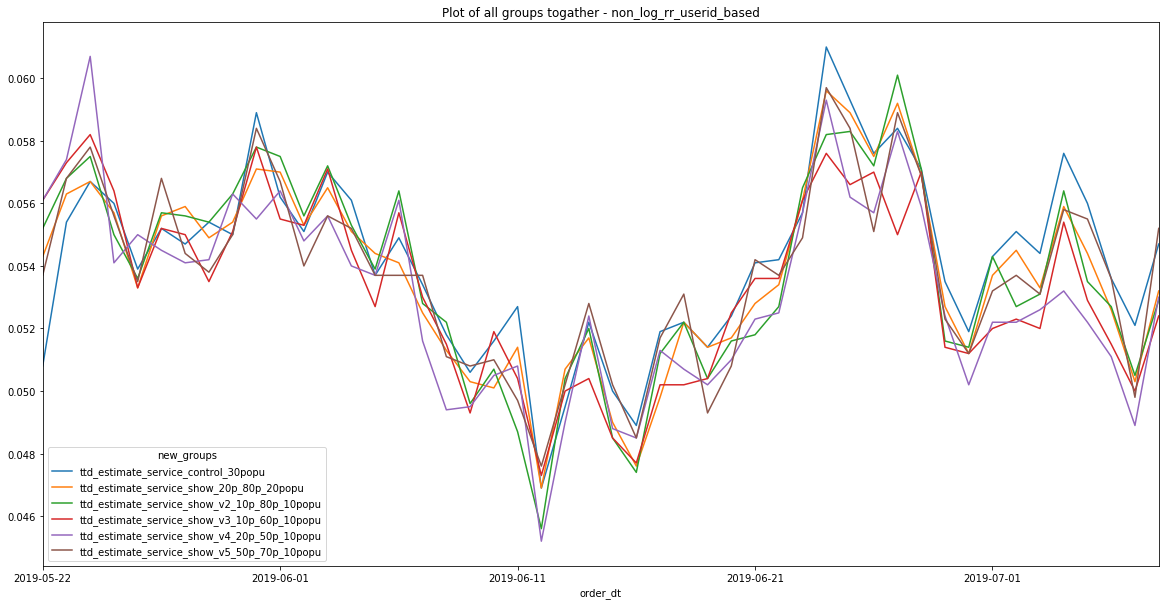

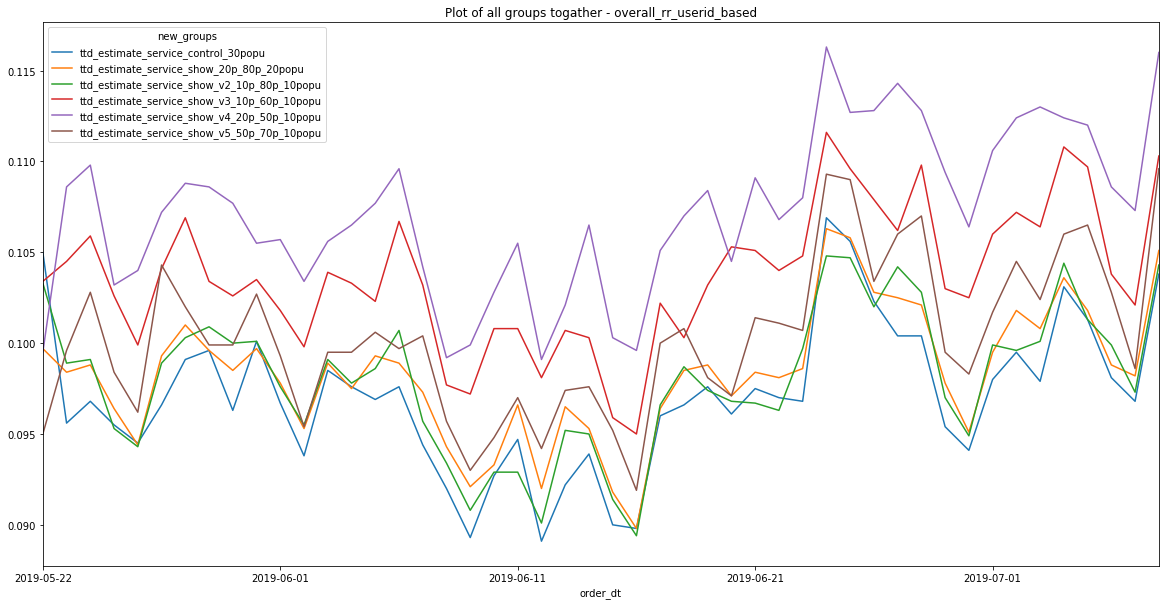

In [16]:
metrics = ['lrr_userid_based','non_log_rr_userid_based','overall_rr_userid_based']
for metric in metrics:
    df_lrr_dt[['order_dt','new_groups',metric]].pivot_table(columns='new_groups', values=metric, index='order_dt').plot(figsize=(20, 10))
    plt.title('Plot of all groups togather - {}'.format(metric))

## top countries

In [29]:
df_lrr_dt_country.head()

new_groups    order_dt shipping_country  \
0     ttd_estimate_service_show_20p_80p_20popu  2019-07-04               US   
1  ttd_estimate_service_show_v2_10p_80p_10popu  2019-05-28               US   
2  ttd_estimate_service_show_v2_10p_80p_10popu  2019-06-29               US   
3  ttd_estimate_service_show_v2_10p_80p_10popu  2019-05-28               BR   
4  ttd_estimate_service_show_v3_10p_60p_10popu  2019-06-07               GB   

   user_count  lrr_userid_based  llr_stddev_userid_based  \
0       32980            0.0213                   0.1442   
1       30971            0.0150                   0.1215   
2       35896            0.0237                   0.1521   
3        7123            0.0682                   0.2522   
4        3860            0.0231                   0.1501   

   non_log_rr_userid_based  non_log_rr_stddev_userid_based  \
0                   0.0363                          0.1870   
1                   0.0428                          0.2024   
2                   0.0348                          0.1833   
3                   0.2142                          0.4103   
4                   0.0246                          0.1550   

   overall_rr_userid_based  overall_rr_stddev_userid_based  orders  \
0                   0.0600                          0.2374  110112   
1                   0.0591                          0.2359   89989   
2                   0.0607                          0.2387  107979   
3                   0.2885                          0.4531   18241   
4                   0.0492                          0.2164    9837   

   l_refund_orders  non_l_refund_orders  overall_refund_orders  lrr_txn_based  \
0             3329                 6435                   9764       0.030233   
1             1954                 5843                   7797       0.021714   
2             2994                 6586                   9580       0.027728   
3             1624                 5109                   6733       0.089030   
4              324                  423                    747       0.032937   

   non_l_rr_txn_based  overall_rr_txn_based  
0            0.058440              0.088673  
1            0.064930              0.086644  
2            0.060993              0.088721  
3            0.280083              0.369114  
4            0.043001              0.075938

____________________________________________________________________________________________________
____________________________________________________________________________________________________
____________________________________________________________________________________________________
____________________________________________________________________________________________________
____________________________________________________________________________________________________
____________________________________________________________________________________________________


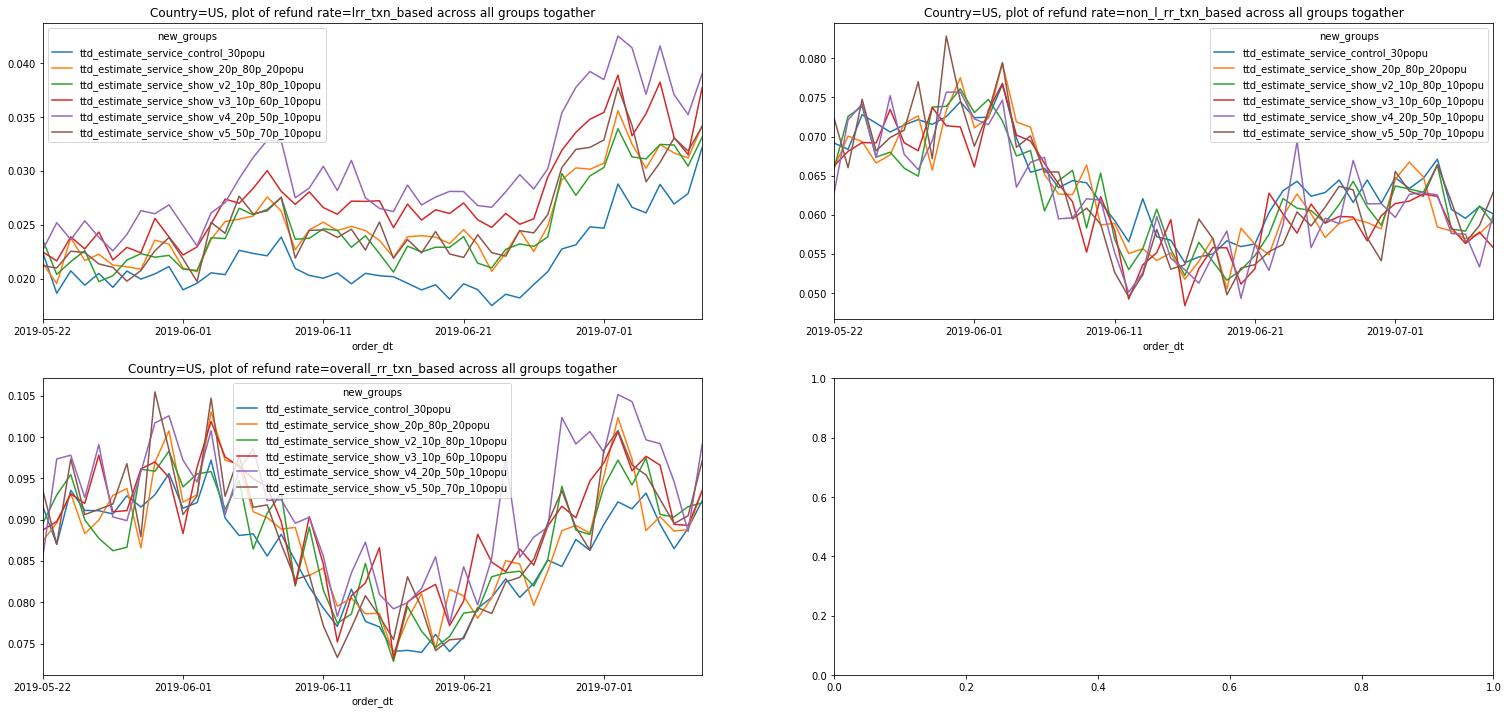

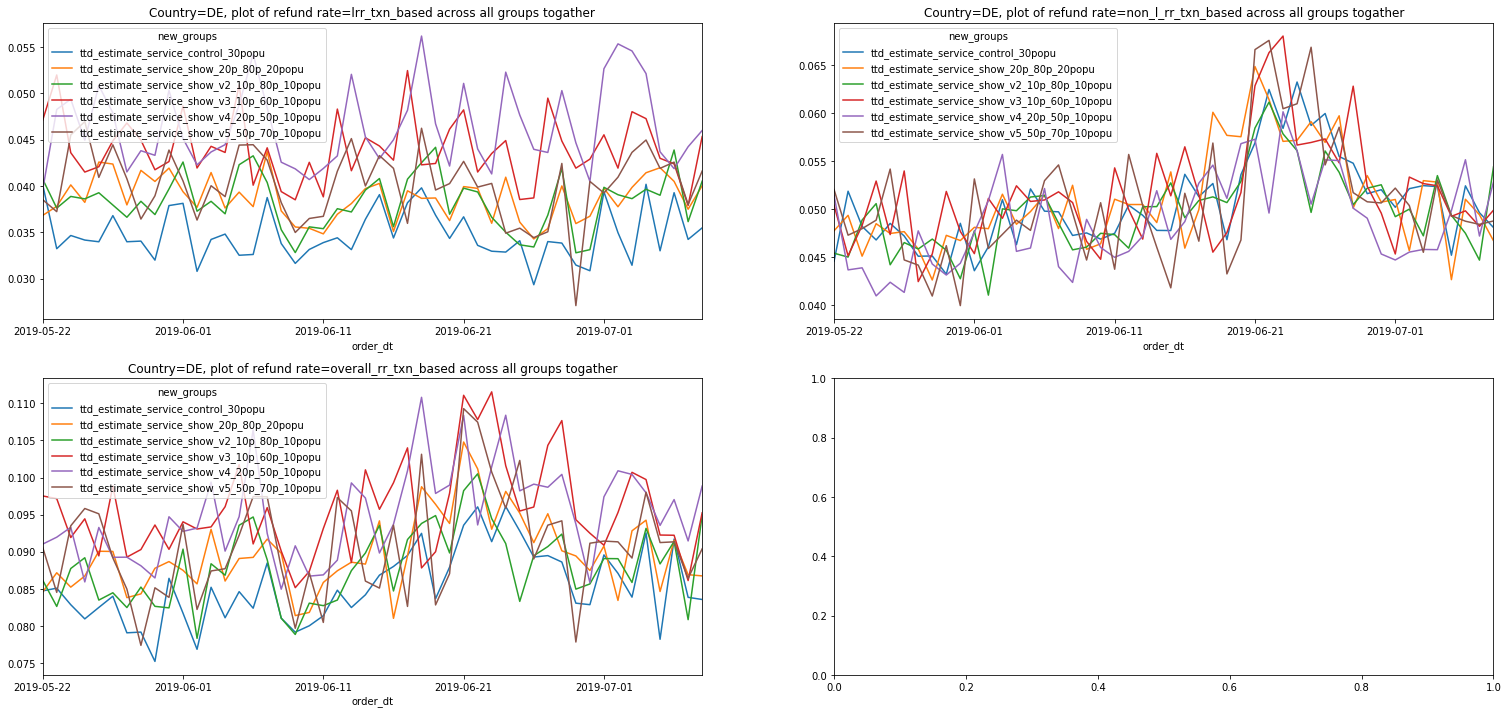

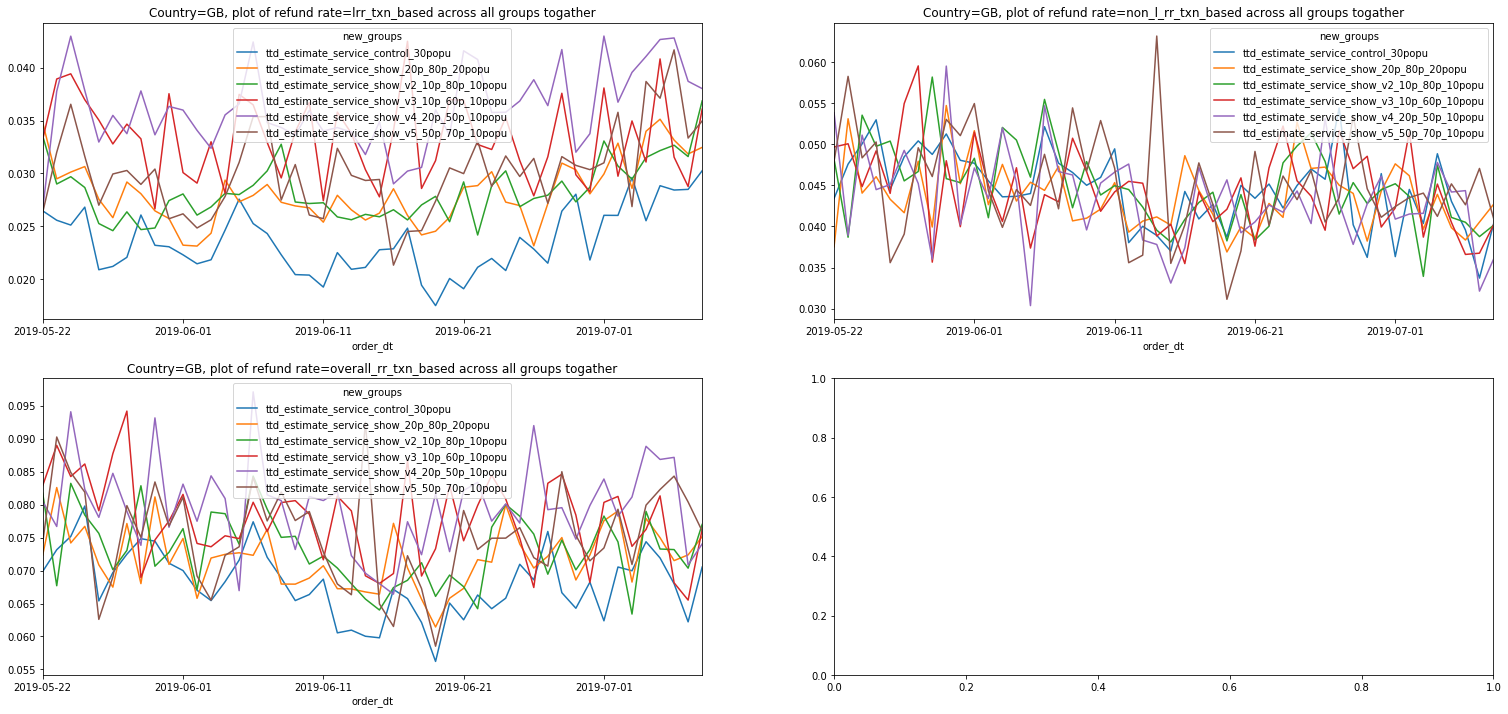

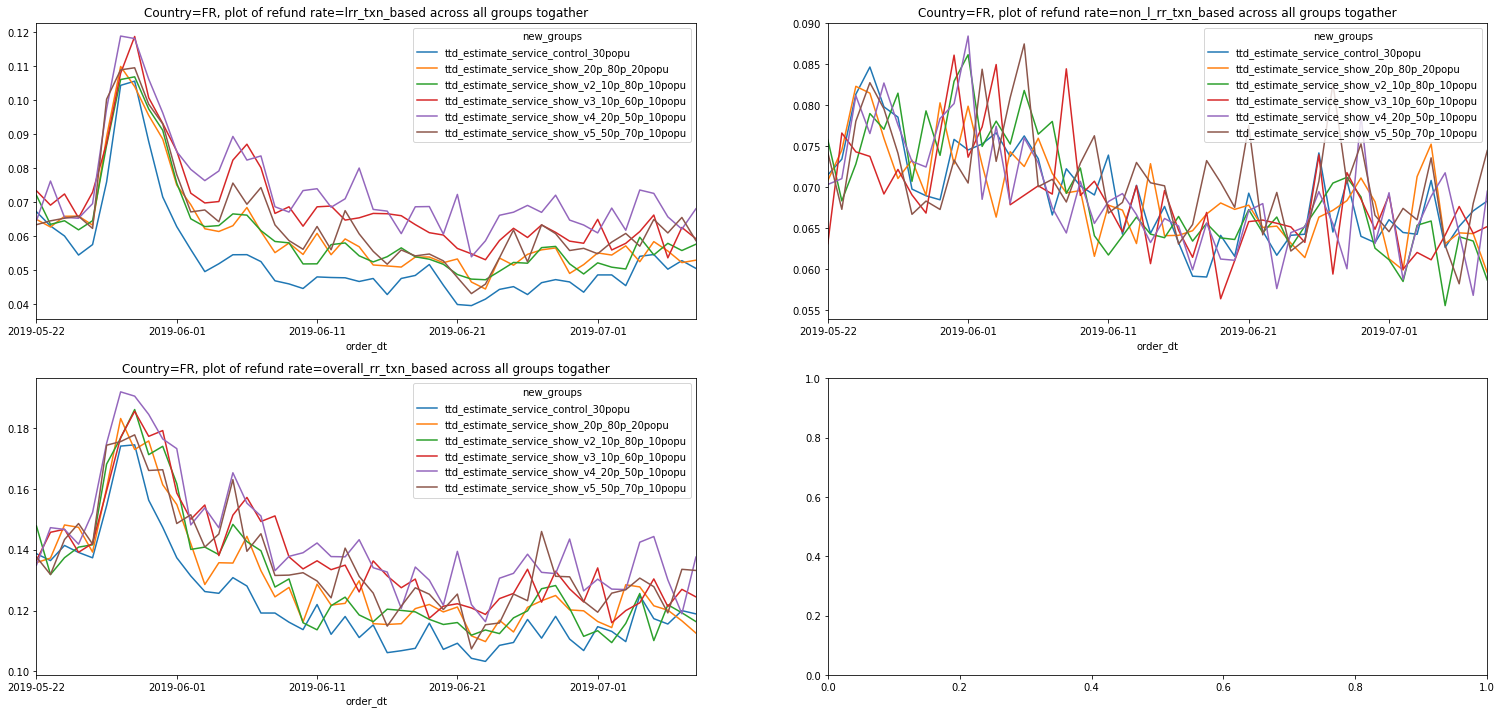

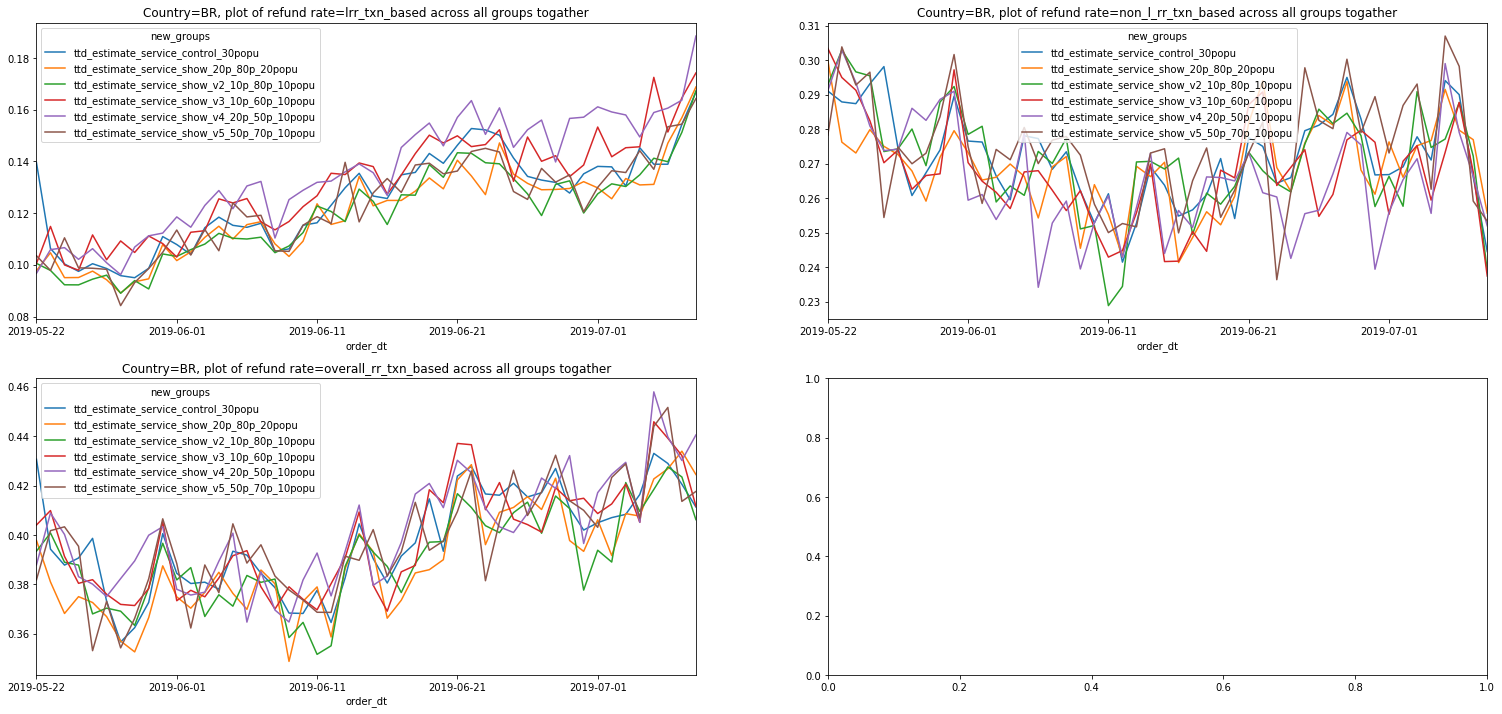

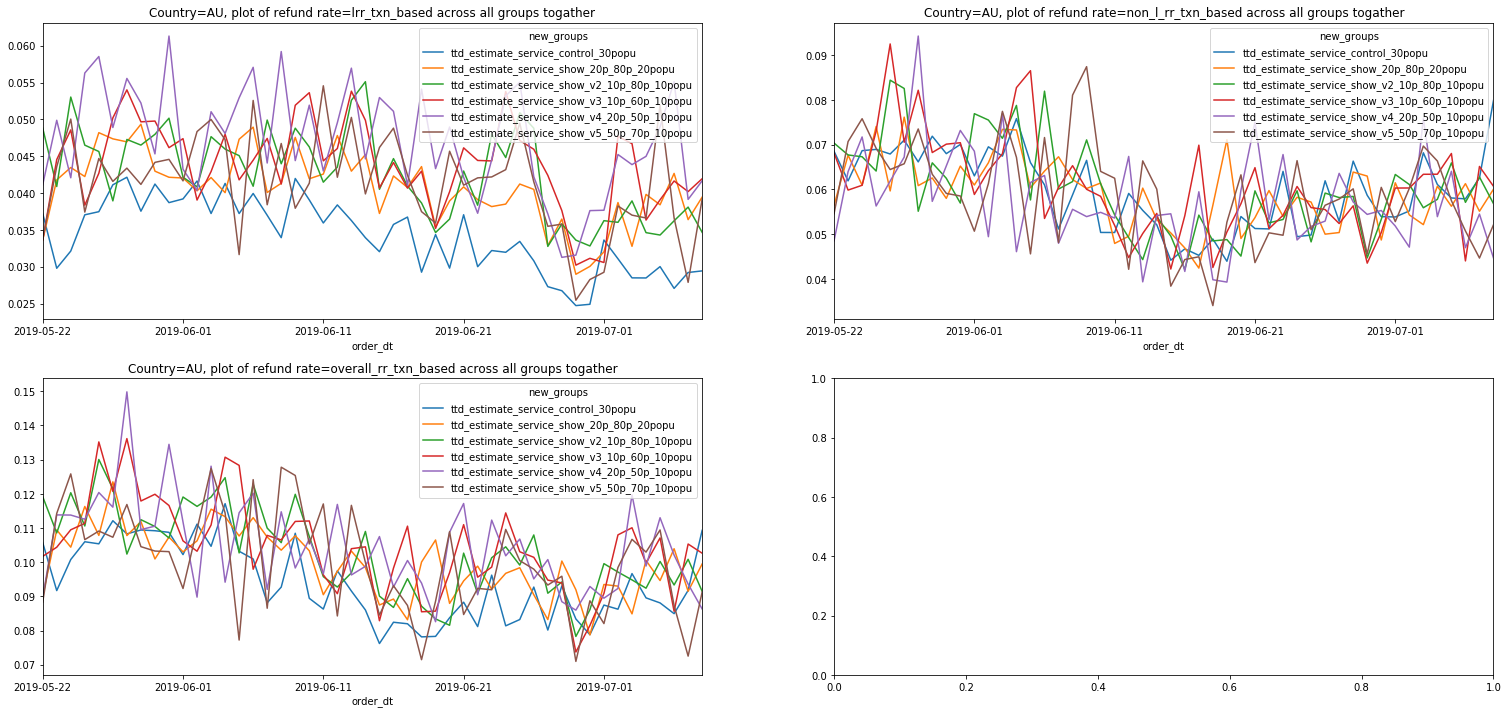

In [35]:
# df_lrr_dt_country_group =  df_lrr_dt_country.groupby(['new_groups','shipping_country','order_dt'],as_index=False)['orders','l_refund_orders','non_l_refund_orders','overall_refund_orders'].sum()
metrics = ['lrr_txn_based','non_l_rr_txn_based','overall_rr_txn_based']
countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU']

for c in countries:
    m = 2
    n = (len(metrics)+1) // m
    fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))
    for i in range(len(metrics)):
        x = i//m
        y = i%m
        df_lrr_dt_country.loc[df_lrr_dt_country.shipping_country==c,['order_dt','new_groups',metrics[i]]].pivot_table(columns='new_groups', values=metrics[i], index='order_dt')\
        .plot(ax=axes[x][y], title='Country={}, plot of refund rate={} across all groups togather'.format(c,metrics[i]))